### Source

[1] Yann LeCun, Leon BottouGenevieve, B. Orr & KlausRobert Müller. (2002). *Efficient BackProp*. Springer  
[2] Keras documentation : https://keras.io/getting-started/functional-api-guide/

### Importation des librairies et données 

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools

from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# Keras : couche haut niveau pour réseau de neuronne (backend : Tensorflow)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.vis_utils import model_to_dot

# Pour l'affichage du RNN
from IPython.display import SVG

#Seed fixé pour la reproductibilité
seed = 2

Using TensorFlow backend.


In [0]:
# Chargement des jeux de données
xtrain = pd.read_csv('***')
ytrain =  pd.read_csv('***')
xtest = pd.read_csv('***')

### Exploration des données

#### Description 

D'après l'énoncé :

    colonnes 1-14 - 14 qualité de l'image A;
    colonnes 15-28 - 14 qualité de l'image B;
    colonnes 29-36 - 8 scores de proximité entre les images A et B.

Ainsi, les données d'entrée sont séparées en selon les 3 vecteurs ci-dessus afin de pouvoir comparer indépendamment les images A et B.

In [0]:
# Jeu d'apprentissage
imageA_train = xtrain.iloc[:,:14]
imageB_train = xtrain.iloc[:,14:28]
matching_train = xtrain.iloc[:,28:]

# Jeu de test
imageA_test = xtest.iloc[:,:14]
imageB_test = xtest.iloc[:,14:28]
matching_test = xtest.iloc[:,28:]

#### Taille du jeu de données

In [0]:
print(f'Nombre d\'observation : {xtrain.shape[0]}\n'
      f'Nombre de variables : \n Images A = images B : {imageA_train.shape[1]}\n \
Fusion de A et B : {matching_train.shape[1]}')

Nombre d'observation : 3196465
Nombre de variables : 
 Images A = images B : 14
 Fusion de A et B : 8


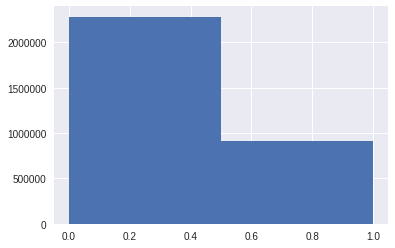

In [0]:
plt.figure()
plt.hist(ytrain.values, bins=2)
plt.show()

In [0]:
print(f'Il y a environ : {(ytrain[ytrain==1].count()/ytrain.count()).values[0]*100:.0f}% \
de class 1 = \"visages simliaires\" dans le jeu d\'apprentissage.')

Il y a environ : 29% de class 1 = "visages simliaires" dans le jeu d'apprentissage.


Un estimateur qui prédirait toujours 0 aurait une précision de 0.7 environ.

#### Analyse de la banque d'image

Une fois la séparation entre image A et B, on observe le nombre d'image unique dans le jeu d'apprentissage et dans le jeu d'apprentissage + jeu de test.

In [0]:
unique_train = pd.concat([imageA_train, imageB_train]).drop_duplicates().shape
# = (143709, 28) 
unique_train_test_B = pd.concat([imageA_train, imageB_train, imageB_test]).drop_duplicates().shape
# = (143753, 28)
unique_train_test_A = pd.concat([imageA_train, imageB_train, imageA_test]).drop_duplicates().shape
# = (143719, 28)

In [0]:
print('Images uniques dans le jeu d\'apprentissage : ', unique_train[0])
print('Images uniques dans le jeu d\'apprentissage + test : ', \
      (unique_train_test_B[0] + unique_train_test_A[0] - unique_train[0]))
print('Images supplémentaires dasn le jeu d\'apprentissage : ', \
      (unique_train_test_B[0] + unique_train_test_A[0] - 2*unique_train[0]))

Images uniques dans le jeu d'apprentissage :  143709
Images uniques dans le jeu d'apprentissage + test :  143763
Images supplémentaires dasn le jeu d'apprentissage :  54


Comparé au nombre d'observations, 3196465, il n'y a seulement que 143709 observations différentes dans le jeu d'apprentissage, soit un ratio de 5%; et seulement 54 en plus dans le jeu de test.  
Cette information nous indique que beaucoup de couple image A/B sont créés à partir des mêmes images, notre modèle ne sera probablement pas généralisable à d'autres images. Ainsi l'objectif est bien ici de déterminer si **deux visages, précédemment associées à d'autre visages, sont équivalents**.  

Le jeu de test est construit en conséquence : seul 54 images supplémentaires y sont incluses. Il n'est donc pas demandé d'avoir un modèle qui se généraliserait à d'autres images, mais bien de pouvoir identifier de nouveaux couples.

#### Est-ce que 2 images ont toujours le même vecteur de proximité ?

1. Dans un premier temps on détecte les lignes équivalentes dans "matching_train". => 439451 lignes équivalentes
2. Puis on isole une ligne en particulier identifiée à l'étape 1.
3. On affiche les lignes avec la même valeur de "matching" et n vérifie que image A = image B et image B = image A

In [0]:
xtrain[matching_train.duplicated()].head(10)
print('Nombre de lignes dupliquées : ', xtrain[matching_train.duplicated()].count()[0])

Nombre de lignes dupliquées :  439451


In [0]:
# Création d'un masque pour identifier les lignes équivalente à la 5246
mask = (matching_train == matching_train.iloc[5246,:].values).iloc[:,0]
unique_matching = xtrain[mask][:2]

In [0]:
print('Les 2 images sont-elles identiques ? ')
print('image A = image B :', np.all(unique_matching.iloc[0,:14].values == unique_matching.iloc[1,14:28]))
print('image B = image A :', np.all(unique_matching.iloc[1,:14].values == unique_matching.iloc[0,14:28]))

Les 2 images sont-elles identiques ? 
image A = image B : True
image B = image A : True


En conclusion:
- Notre modèle doit apprendre à identifier les similarité d'images à partir de l'exhaustivité des pairs
- Pour deux images A et B données, leur vecteur de proximité est équvialent quelque soit l'ordre de concatenation dans la construction des observations.

#### Augmentation du jeu de données

Il est donc possible d'augmenter le jeu d'apprentissage en ajoutant des nouvelles pairs en inversant image A et image B.  La classification et le vecteur de proximité reset inchangé.  
Comme vu précédemment, il y a déjà des lignes dupliquées avec image A et image B inversées, il convient donc de supprimer les lignes dupliquées avec l'opération précédente pour ne pas créer de doublons.

In [0]:
size_init = xtrain.shape[0]
print('Taille du jeu de données initial : ', xtrain.shape[0])

Taille du jeu de données initial :  3196465


In [0]:
idx_A = ['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10', 'fA11', 'fA12', 'fA13', 'fA14']
idx_B = ['fB1', 'fB2', 'fB3', 'fB4', 'fB5', 'fB6', 'fB7', 'fB8', 'fB9','fB10', 'fB11', 'fB12', 'fB13', 'fB14']

imageB_train.columns = idx_A
imageA_train.columns = idx_B

inverse_paired = pd.concat([imageB_train, imageA_train, matching_train], axis=1)

In [0]:
xtrain =  pd.concat([xtrain, inverse_paired], axis=0)
xtrain.reset_index(inplace=True, drop=True)
xtrain.drop_duplicates(inplace=True)

ytrain = pd.concat([ytrain,ytrain], axis=0)
ytrain = ytrain.iloc[xtrain.index]

In [0]:
size_init = xtrain.shape[0]
print('Taille du jeu de données augmenté : ', xtrain.shape[0])

Taille du jeu de données augmenté :  5514026


### Transformation des variables

#### Standardisation des données

D'après la source [1], il est primordial de centrer réduire les données dans le cadre de l'exploitation d'un réseau de neurone.  
A noter : Pour éviter de capter des informations du jeu de test (variance / moyenne), le calibrage se fait uniquement sur le jeu d'apprentissage.

In [0]:
# Standardisation des données (centrée-réduite)
# (X - moyenne(X)) / ecart_type(X)

std = StandardScaler()
xtrain_std = std.fit_transform(xtrain)
xtest_std = std.transform(xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [0]:
print('Jeu d\'apprentissage : \nDonnées réduites ?', np.allclose(np.std(xtrain_std, axis=0), 1,rtol=1e-05, atol=1e-08) )
print('Données centrées ?', np.allclose(np.mean(xtrain_std, axis=0), 0,rtol=1e-05, atol=1e-08)  )

Jeu d'apprentissage : 
Données réduites ? True
Données centrées ? True


### Modélisation

#### Split jeu d'apprentissage / jeu de test

Il est préconisé dans le rapport [1] de maximiser le mélange des données. Afin de réaliser cette opération et de conserver le ratio d'origine entre la classe 1 et 0, la fonction StratifiedShuffleSplit de sklearn est utilisée.

In [0]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=2)

n_train = len(xtrain_std)
xtrain_lite = xtrain_std[0:n_train, :]
ytrain_lite = np.array(ytrain[0:n_train])

#n_val = 500000
#xval = xtrain_std[n_train+1:n_train+n_val,:]
#yval = np.array(ytrain[n_train+1:n_train+n_val])

for train_index, test_index in itertools.islice(sss.split(xtrain_lite, ytrain_lite), 1):
#  print("TRAIN:", train_index, "TEST:", test_index)
  xtrain_strat, xtest_strat = xtrain_lite[train_index,:], xtrain_lite[test_index,:]
  ytrain_strat, ytest_strat = ytrain_lite[train_index], ytrain_lite[test_index]

#### Définition du réseau de neuronne "full-connexion" ou perceptron multi-couche

Comme préconisé dans le rapport [1], les poids sont initialisés selon une distribution gaussiene.
L'ordre de grandeur du nombre de neurone a été défini depuis la formule :


Nh=Ns(α∗(Ni+No))

Ni= nombre de neurone d'entrée.  
No = nombre de neurone de sortie.  
Ns = nombre d'échantillon dans le jeu d'apprentissage.  
α = coefficient arbitraire entre 2-10.  

Le drop permet de rendre le modèle plus généralisable en désactivant un certain nombre de neurone aléatoirement à chaque batch.

In [0]:
# Dimension of input layer (first layer)
input_dim = xtrain_strat.shape[1]

# create model
# Output layer remains one, because it's a binary classification
model = Sequential()

model.add(Dense(units=3000, input_dim=input_dim, kernel_initializer='RandomNormal', activation='relu', name='Input_layer'))
model.add(Dropout(0.1, seed=seed))

model.add(Dense(units=3000, activation='relu', name='Hidden_layer_2'))
model.add(Dropout(0.1, seed=seed))

model.add(Dense(1, activation='sigmoid', name='Classification_layer'))

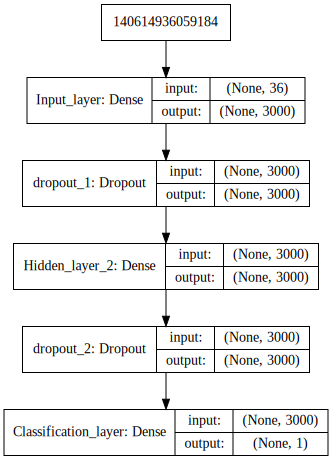

In [0]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

#### Prédiction
 - Une validation croisée manuelle a permis de déterminer que la fonction d'optimisation "Adam" ainsi que le taux d'apprentissage par défaut (lr=0.001) sont  efficaces dans notre situation.
 - La fonction de coût "binary_crossentropy" est pertinente dans le cas de la classification binaire.  
 - La métrique "accuracy" est imposé par l'énoncé.

In [0]:
# Compile model

from keras import optimizers

optim = optimizers.Adam()
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

xtrain_fit = xtrain_strat
ytrain_fit = ytrain_strat

xtest_fit = xtest_strat
ytest_fit = ytest_strat

# Evaluate model with standardized dataset
history = model.fit(xtrain_fit, ytrain_fit, epochs=10, batch_size=200, verbose=1, validation_data = (xtest_fit, ytest_fit), shuffle=0)
print('------- END -------')

Train on 4962623 samples, validate on 551403 samples
Epoch 1/10
4962623/4962623 [==============================] - 927s 187us/step - loss: 0.0497 - acc: 0.9816 - val_loss: 0.0437 - val_acc: 0.9837
Epoch 2/10
4962623/4962623 [==============================] - 924s 186us/step - loss: 0.0439 - acc: 0.9837 - val_loss: 0.0423 - val_acc: 0.9843
Epoch 3/10
4962623/4962623 [==============================] - 923s 186us/step - loss: 0.0421 - acc: 0.9843 - val_loss: 0.0409 - val_acc: 0.9849
Epoch 4/10
2411100/4962623 [=============>................] - ETA: 7:48 - loss: 0.0412 - acc: 0.9846Buffered data was truncated after reaching the output size limit.

In [0]:
# Evaluation finale du modèle sur un jeu de données jamais utilisé
model.evaluate(xval, yval)

#### Courbe d'apprentissage

In [0]:
plt.figure(figsize=(10,6))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# save the model
#filename = 'RNN_epochs10_batch100_RandomNormal_strat_boosted_adam.sav'
#joblib.dump(model, filename)

##model = joblib.load('RNN_epochs10_batch100_RandomNormal_strat_boosted_adam.sav') 

In [0]:
# Prédiction sur le jeu de tes et sauvegarde
xtest_std = std.transform(xtest)

ytest = model.predict(xtest_std)
print(ytest.shape)
np.savetxt('ytest_challenge_student.csv', ytest, fmt = '%1.0d', delimiter=',')

#### Conclustion

Il y a une importance primordiale à entrainer le modèle sur tout le jeu de données pour mutliplier au maximum les pairs d'image A et B. En prenant plus de temps pour entrainer le modèle, on pourrait augmenter le jeu d'entrainement au jeu entier et diminuer la taille du batch.
Le nombre d'epoch semble suffisant car la précision converge.